# Multi-Instrument Dashboard

## Setup AIA and XRT

### Import Statements

In [1]:
# %pip install astropy scipy ipympl ndcube numba xrtpy sunpy lxml drms zeep
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))


import importlib, numpy as np
from sys import path
import time, os, copy
import matplotlib as mpl
mpl.use("qt5Agg")
# Enable interactive plotting with widgets
%matplotlib widget

from sunpy.map import Map
from sunpy.net import Fido, vso, attrs as a
from sunpy.time import TimeRange
from ndcube import NDCube, NDCubeSequence, NDCollection
from astropy import wcs

import astropy.units as u
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 18}) # Make the fonts in figures big enough for papers
# plt.rcParams.update({'figure.figsize':[27,15]})
plt.rcParams.update({'image.origin':'lower'})
np.set_printoptions(linewidth=128)

base_path = os.getcwd()

import EMToolKit.EMToolKit as emtk
from EMToolKit.visualization.dashboard import dashboard_object
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper
from EMToolKit.instruments.xrt import xrt_wrapper
from EMToolKit.algorithms.sparse_em_wrapper import sparse_em_wrapper
from EMToolKit.algorithms.simple_reg_dem_wrapper import simple_reg_dem_wrapper
from EMToolKit.algorithms.sparse_nlmap_dem_wrapper import autoloading_sparse_nlmap_dem_wrapper

In [2]:
import EMToolKit
import EMToolKit.visualization
importlib.reload(EMToolKit)
importlib.reload(EMToolKit.visualization)
importlib.reload(EMToolKit.visualization.dashboard)
import EMToolKit.EMToolKit as emtk
from EMToolKit.visualization.dashboard import dashboard_object
em_collection=0

In [3]:
daystr = '20100725'
date='2010/07/25 17:58:44'
data_path = os.path.join(base_path,'.data',daystr)


from EMToolKit.instruments.aia import download_sdo_data
from EMToolKit.instruments.xrt import download_xrt_data

date='2010/07/25 17:58:44'
redownload=False
# Download the data
aia_paths, sdo_data_dir = download_sdo_data(base_path, date, redownload=redownload)
xrt_paths, xrt_data_dir = download_xrt_data(base_path, date, redownload=redownload)
paths = aia_paths + xrt_paths




Found 6 AIA images on disk.
Found 1 xrt images on disk.


### Load and Crop the Imagery

In [4]:
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper
from EMToolKit.instruments.xrt import xrt_wrapper

xl, yl, = 240*u.arcsec, -525*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
                                      # Right edge of FOV in arcseconds (relative to disk center)
xlen, ylen  = 270*u.arcsec, 240*u.arcsec # X size of FOV in arcseconds # Y size of FOV in arcseconds


# Load the AIA Images ###
aiamaps = load_from_paths(aia_paths,xl=xl,yl=yl,dx=xlen,dy=ylen)

temperature_array = np.arange(5.5, 7.5, 0.025)

[maps,errs,trlogts,tresps] = aia_wrapper(aiamaps, temperature_array=temperature_array)


In [5]:

# Load the XRT Image ###
    # We're loading these separately so that we can apply an offset to the XRT data -- there appears
    # to be a significant misalignment based on manual inspection and testing:

xrt_offsets = [-5*u.arcsec, -20*u.arcsec]
xrtmap = load_from_paths([[paths[0]],xrt_paths[0]],xl=xl+xrt_offsets[0],yl=yl+xrt_offsets[1],dx=xlen,dy=ylen)[1]
xrtmap.meta['crval1'] -= xrt_offsets[0].value
xrtmap.meta['crval2'] -= xrt_offsets[1].value

[xrtmaps,xrterrs,xrt_trlogts,xrt_tresps] = xrt_wrapper([xrtmap], temperature_array=temperature_array)

# # Append the XRT data to the AIA data <- Key point
maps.append(xrtmaps[0])
errs.append(xrterrs[0])
trlogts.append(xrt_trlogts[0])
tresps.append(xrt_tresps[0])


In [6]:

# Normalizing the response functions makes them much easier for the solver to handle.
datmax_nominal = 1.0e4 # The nominal maximum of the data
overall_norm = datmax_nominal/np.max(np.array(tresps))
norms = np.max(np.array(tresps),axis=0)/np.max(np.array(tresps))/overall_norm

In [7]:
# Make data sequence from AIA + XRT data:
datasequence = emtk.em_data(maps,errs,trlogts,tresps)

# Create em_collection with AIA + XRT data:
em_collection = emtk.em_collection(datasequence)

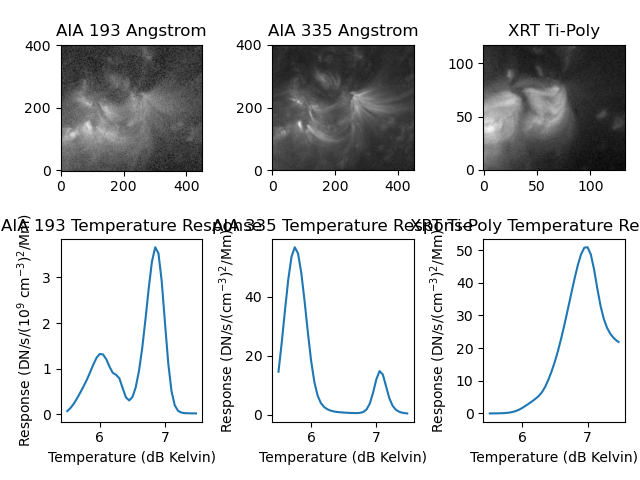

In [8]:
# Show some of the AIA channels and their temperature responses for illustration:
plt_emmax = 5.0e28
gfac = 1.0/2.2

fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(np.clip(maps[1].data/np.max(tresps[1]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,0].set(title='AIA 193 Angstrom')
axs[1,0].plot(trlogts[1],tresps[1]/1.0e-27)
axs[1,0].set(title='AIA 193 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(10$^9$ cm$^{-3})^2$/Mm)')

axs[0,1].imshow(np.clip(maps[2].data/np.max(tresps[2]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,1].set(title='AIA 335 Angstrom')
axs[1,1].plot(trlogts[2],tresps[2]/1.0e-27)
axs[1,1].set(title='AIA 335 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

axs[0,2].imshow(np.clip(maps[-1].data/np.max(tresps[-1]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,2].set(title='XRT Ti-Poly')
axs[1,2].plot(trlogts[-1],tresps[-1]/1.0e-27)

axs[1,2].set(title='XRT Ti-Poly Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## DEM Analysis

### Compute the Differential Emission Measure

In [10]:
sparse_nlmap_demsequence, multi_out = autoloading_sparse_nlmap_dem_wrapper(datasequence, recalc=False, wrapargs={'norms':norms, 'overall_norm':overall_norm})
em_collection.add_model(sparse_nlmap_demsequence)

Calculating sparse_nlmap_demsequence from scratch...

 10%|▉         | 18090/189010 [00:10<01:53, 1505.29it/s]

### Run the Dashboard

In [ ]:
# Get the most recent version from the tool kit:
from EMToolKit.visualization.dashboard import dashboard_object
importlib.reload(EMToolKit.visualization.dashboard)
from EMToolKit.visualization.dashboard import dashboard_object

# Suppress specific SunpyMetadataWarning
import warnings
from sunpy.util.exceptions import SunpyMetadataWarning
warnings.filterwarnings("ignore", category=SunpyMetadataWarning)

In [ ]:
# Create the dashboard:
dash = dashboard_object(em_collection, xsize=8, ysize=4, fontsize=8)
dash.display(False)

In [ ]:
multi_synthmaps = [em_collection.synthesize_map(map) for map in em_collection.data()]
multi_synthdata = [map for map in multi_synthmaps]

In [ ]:
def calc_resids(synthdata, em_collection):# Calculate the residuals and Chi squared:
	ndata = len(synthdata)
	resids = []
	datasequence = em_collection.data()
	chi2 = 0
	[nx,ny] = datasequence[0].data.shape
	for seq in datasequence: [nx,ny] = [np.min([seq.data.shape[0],nx]),np.min([seq.data.shape[1],ny])]
	for i in range(0,ndata):
		resids.append(((synthdata[i].data-datasequence[i].data)/datasequence[i].uncertainty.array)**2)
		chi2 += np.mean(resids[i])/ndata
	return resids, chi2

#spars_resids, spars_chi2 = calc_resids(spars_synthdata,em_collection)
#simpl_resids, simpl_chi2 = calc_resids(simpl_synthdata,em_collection)
multi_resids, multi_chi2 = calc_resids(multi_synthdata,em_collection)
print("Multi-instrument Chi squared = ",multi_chi2)
#print('simple_reg_dem Chi squared = ',simpl_chi2, 'spars_em Chi squared = ',spars_chi2)

In [ ]:
# Plot Residuals:
fig = plt.figure(figsize=[20,12])
plt.suptitle('Residuals for '+multi_algorithm)
for i in range(0,7):
    ax1 = fig.add_subplot(2,4,i+1)
    ax1.imshow(multi_resids[i],vmin=0,vmax=5)
    ax1.set(title=em_collection.data()[i].meta['channel'])

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


class dashboard_object(object):
    def __init__(self,em_collection):
        self.emc = em_collection

    def widgwrap(self, xpt, ypt, rtemp, gtemp, btemp, sigma, algorithm):
        dashboard_object(self.emc, plotpoint=[xpt,ypt], temperatures=[rtemp,gtemp,btemp], sigmas=sigma, algorithm=algorithm)

In [ ]:
importlib.reload(EMToolKit.visualization.dashboard)
from EMToolKit.visualization.dashboard import dashboard_object
dash = dashboard_object(em_collection)

In [ ]:
[nx,ny] = dash.emc.collection[dash.emc.collection['models'][0]][0].data.shape
xpt=widgets.IntSlider(min=0, max=nx, value=10, step=1, description='xpt', continuous_update=False)
ypt=widgets.IntSlider(min=0, max=ny, value=100, step=1, description='ypt', continuous_update=False)
rtemp=widgets.FloatSlider(min=5, max=7, value=5.8, step=0.05, description='rtemp', continuous_update=False)
gtemp=widgets.FloatSlider(min=5, max=7, value=6.1, step=0.05, description='gtemp', continuous_update=False)
btemp=widgets.FloatSlider(min=5, max=7, value=6.4, step=0.05, description='btemp', continuous_update=False)
sigma=widgets.FloatSlider(min=0.025, max=0.5, value=0.125, step=0.01, description='sigma', continuous_update=False)
algorithm=widgets.Dropdown(options=dash.emc.collection['models'], description='algorithm', continuous_update=False)
ui = widgets.HBox([xpt,ypt,rtemp,gtemp,btemp,sigma,algorithm])
out = widgets.interactive_output(dash.widgwrap, {'xpt':xpt,'ypt':ypt,'rtemp':rtemp,'gtemp':gtemp,'btemp':btemp,'sigma':sigma,'algorithm':algorithm})
display(ui,out)